In [15]:
import os

import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import kagglehub
from kagglehub import KaggleDatasetAdapter

import re
import traceback
import joblib
from scipy import sparse
import string as s

from bs4 import BeautifulSoup

from tqdm import tqdm
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin, BaseEstimator

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

tqdm.pandas()

nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\2024\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\2024\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\2024\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
file_path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")


In [83]:
fake_news_df = pd.read_csv(os.path.join(file_path, "Fake.csv"))
true_news_df = pd.read_csv(os.path.join(file_path, "True.csv"))

In [84]:
print("Fake news dataframe size: ", fake_news_df.shape)
print("True news dataframe size: ", true_news_df.shape)
print("Total original news count: ", fake_news_df.shape[0] + true_news_df.shape[0])


Fake news dataframe size:  (23481, 4)
True news dataframe size:  (21417, 4)
Total original news count:  44898


In [85]:
fake_news_df.loc[:, 'is_fake'] = True
true_news_df.loc[:, 'is_fake'] = False
news_df = pd.concat([fake_news_df, true_news_df], ignore_index=True)

In [86]:
news_df['subject'] = news_df.subject.astype('category').cat.codes

In [87]:
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')
news_df['year'] = news_df['date'].dt.year
news_df['month'] = news_df['date'].dt.month
news_df['dayofweek'] = news_df['date'].dt.dayofweek

In [88]:
for col in ['year', 'month', 'dayofweek']:
    news_df.loc[:, col] = news_df[col].fillna(news_df[col].mode()[0])

In [89]:
news_df.drop_duplicates(subset=['title', 'subject', 'text', 'date', 'is_fake'], keep='last', inplace=True)

In [90]:
empty_mask = news_df['text'].isna() | (news_df['text'].str.strip() == '')
news_df = news_df[~empty_mask].reset_index(drop=True)

In [101]:
print("News dataframe size: ", news_df.shape)
print("Dataframe columns: ", news_df.columns.tolist())

News dataframe size:  (44054, 8)
Dataframe columns:  ['title', 'text', 'subject', 'date', 'is_fake', 'year', 'month', 'dayofweek']


In [102]:
# def plot_wordcloud(data_df, id: bool = False, column='text'):
#     _desc = data_df.loc[data_df['is_fake'] == id, column]
#     plt.figure(figsize=(6, 6))
#     wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(_desc))
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis('off')
#     plt.show()


In [103]:
# plot_wordcloud(news_df, False)

In [104]:
# plot_wordcloud(news_df, True)

In [105]:
news_df[['subject', 'is_fake']].value_counts()

subject  is_fake
6        False      11216
7        False       9991
2        True        9050
5        True        6430
4        True        4308
0        True        1498
3        True         783
1        True         778
Name: count, dtype: int64

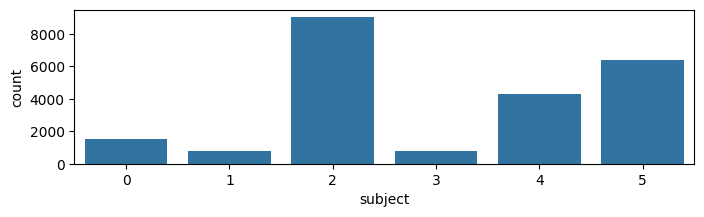

In [106]:
plt.figure(figsize=(8, 2))
sns.countplot(x='subject', data=news_df[news_df.is_fake == True])
plt.show()

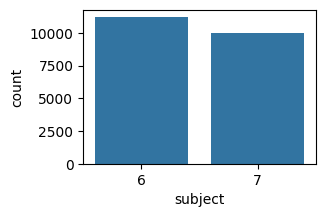

In [107]:
plt.figure(figsize=(3, 2))
sns.countplot(x='subject', data=news_df[news_df.is_fake == False])
plt.show()


In [108]:
cleaned_news_df = news_df.drop(columns=['title', 'date'])


In [109]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        return pd.Series(self._preprocess_sentences(X), index=X.index)

    def _preprocess_text(self, text):
        text = text.lower().strip()
        text = BeautifulSoup(text, "html.parser").get_text()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token.isalpha()]
        
        return ' '.join(tokens)
    
    def _preprocess_sentences(self, sentences):
        return sentences.progress_apply(self._preprocess_text)
 
preprocessor = TextPreprocessor()

In [110]:
cleaned_news_df.loc[:, 'text'] = preprocessor.transform(cleaned_news_df.text)

100%|██████████| 44054/44054 [03:04<00:00, 238.57it/s]


In [111]:
cleaned_news_df.columns.tolist()

['text', 'subject', 'is_fake', 'year', 'month', 'dayofweek']

In [114]:
empty_mask = cleaned_news_df['text'].isna() | (cleaned_news_df['text'].str.strip() == '')
cleaned_news_df = cleaned_news_df[~empty_mask].reset_index(drop=True)

In [115]:
os.makedirs('./_resources/models', exist_ok=True)
cleaned_news_df.to_csv('./_resources/preprocessed.csv', index=False, sep='|')

In [3]:
_df = pd.read_csv('./_resources/preprocessed.csv', sep='|')
numeric_cols = ['subject', 'year', 'month', 'dayofweek']
X = _df[['text', *numeric_cols]]
y = _df['is_fake']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (35174, 5), Test: (8794, 5)


In [5]:
X_train_tabular = X_train[numeric_cols].values
X_test_tabular = X_test[numeric_cols].values

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))
tfidf.fit(X_train.text)
joblib.dump(tfidf, './_resources/models/tfidf_vectorizer.joblib')

['./_resources/models/tfidf_vectorizer.joblib']

In [6]:
tfidf = joblib.load('./_resources/models/tfidf_vectorizer.joblib')

In [11]:
X_train_text_tfidf = tfidf.transform(X_train.text)
X_test_text_tfidf = tfidf.transform(X_test.text)
print("No. of features extracted:")
print(len(tfidf.vocabulary_))

No. of features extracted:
3013060


In [12]:
X_train_combined = sparse.hstack((X_train_text_tfidf, X_train_tabular))
X_test_combined = sparse.hstack([X_test_text_tfidf, X_test_tabular])

In [19]:
class ModelEvaluator:
    def __init__(self, models: list):
        self.models = models
        self.results = []

    def evaluate(self, X_train, y_train, X_test, y_test):
        for model_cfg in tqdm(self.models, desc="Evaluating Models", unit="model"):
            model_name = model_cfg.get('name', 'Unnamed Model')
            try:
                model = model_cfg['model'](**model_cfg.get('params', {}))
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                metrics = {
                    'Model': model_name,
                    'Accuracy': accuracy_score(y_test, y_pred),
                    'Precision': precision_score(y_test, y_pred, zero_division=0),
                    'Recall': recall_score(y_test, y_pred, zero_division=0),
                    'F1 Score': f1_score(y_test, y_pred, zero_division=0)
                }
                self.results.append(metrics)

            except Exception as e:
                print(f"\nModel '{model_name}' failed:\n{traceback.format_exc()}")
                self.results.append({'Model': model_name, 'Accuracy': None, 'Precision': None, 'Recall': None, 'F1 Score': None, 'Error': str(e)})

        df = pd.DataFrame(self.results)
        return df.sort_values(by='Accuracy', ascending=False, na_position='last').reset_index(drop=True)

    def save_models(self, results: pd.DataFrame, save_dir: str = "./_resources/models"):
        os.makedirs(save_dir, exist_ok=True)
        results.to_csv("./_resources/evaluations.csv")

        for model in self.models:
            model_name = model.get('name', 'Unnamed Model').lower()
            filename = os.path.join(save_dir, f"{model_name.replace(' ', '_')}.pkl")
            joblib.dump(model, filename)
            print(f"Saved: {filename}")


In [ ]:
models = [
    {
        'name': 'Logistic Regression',
        'model': LogisticRegression,
        'params': {'max_iter': 500, 'random_state': 42}
    },
    {
        'name': 'Ridge Classifier',
        'model': RidgeClassifier,
        'params': {'random_state': 42}
    },
    {
		'name': 'Linear SVM',
		'model': LinearSVC,
		'params': {'C': 0.1, 'dual': True, 'max_iter': 2500, 'random_state': 42}
	},
    {
        'name': 'Random Forest',
        'model': RandomForestClassifier,
        'params': {'n_estimators': 50, 'random_state': 42, 'n_jobs': -1}
    },
    {
        'name': 'Gradient Boosting',
        'model': GradientBoostingClassifier,
        'params': {'n_estimators': 50, 'random_state': 42}
    },
    # {
    #     'name': 'AdaBoost',
    #     'model': AdaBoostClassifier,
    #     'params': {'n_estimators': 50, 'random_state': 42}
    # },
    {
        'name': 'XGBoost',
        'model': XGBClassifier,
        'params': {'use_label_encoder': False, 'eval_metric': 'logloss', 'random_state': 42, 'n_jobs': -1}
    },
    {
        'name': 'LightGBM',
        'model': LGBMClassifier,
        'params': {'random_state': 42, 'n_jobs': -1}
    },
    # {
    #     'name': 'CatBoost',
    #     'model': CatBoostClassifier,
    #     'params': {'verbose': 0, 'random_state': 42}
    # }
]

evaluator = ModelEvaluator(models)
results_df = evaluator.evaluate(X_train_combined, y_train, X_test_combined, y_test)
results_df

Evaluating Models:  22%|██▏       | 2/9 [00:43<02:32, 21.78s/model]e:\Applications\python-projects\eleevo-internship\.venv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Evaluating Models:  56%|█████▌    | 5/9 [10:41<11:58, 179.56s/model]


Model 'AdaBoost' failed:
Traceback (most recent call last):
  File "C:\Users\2024\AppData\Local\Temp\ipykernel_17660\2775312579.py", line 10, in evaluate
    model = model_cfg['model'](**model_cfg.get('params', {}))
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: AdaBoostClassifier.__init__() got an unexpected keyword argument 'n_jobs'



e:\Applications\python-projects\eleevo-internship\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:52:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Evaluating Models:  78%|███████▊  | 7/9 [11:42<03:27, 103.97s/model]

[LightGBM] [Info] Number of positive: 18209, number of negative: 16965
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 5.550097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1574424
[LightGBM] [Info] Number of data points in the train set: 35174, number of used features: 47686
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517684 -> initscore=0.070764
[LightGBM] [Info] Start training from score 0.070764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

e:\Applications\python-projects\eleevo-internship\.venv\Lib\site-packages\lightgbm\basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
Evaluating Models: 100%|██████████| 9/9 [17:42<00:00, 118.05s/model]


Model 'CatBoost' failed:
Traceback (most recent call last):
  File "C:\Users\2024\AppData\Local\Temp\ipykernel_17660\2775312579.py", line 11, in evaluate
    model.fit(X_train, y_train)
  File "e:\Applications\python-projects\eleevo-internship\.venv\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "e:\Applications\python-projects\eleevo-internship\.venv\Lib\site-packages\catboost\core.py", line 2410, in _fit
    self._train(
  File "e:\Applications\python-projects\eleevo-internship\.venv\Lib\site-packages\catboost\core.py", line 1790, in _train
    self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)
  File "_catboost.pyx", line 5023, in _catboost._CatBoost._train
  File "_catboost.pyx", line 5072, in _catboost._CatBoost._train
_catboost.CatBoostError: bad allocation



,Model,Accuracy,Precision,Recall,F1 Score,Error
0,Logistic Regression,1.000000,1.000000,1.000000,1.000000,NaN
1,Linear SVM,1.000000,1.000000,1.000000,1.000000,NaN
2,Gradient Boosting,1.000000,1.000000,1.000000,1.000000,NaN
3,XGBoost,1.000000,1.000000,1.000000,1.000000,NaN
4,LightGBM,1.000000,1.000000,1.000000,1.000000,NaN
5,Ridge Classifier,0.997612,0.999339,0.996046,0.997690,NaN
6,Random Forest,0.986809,0.986190,0.988357,0.987272,NaN
7,AdaBoost,NaN,NaN,NaN,NaN,AdaBoostClassifier.__init__() got an unexpecte...
8,CatBoost,NaN,NaN,NaN,NaN,bad allocation


In [ ]:
evaluator.save_models(results_df)

Saved: ./_resources/models\logistic_regression.pkl
Saved: ./_resources/models\ridge_classifier.pkl
Saved: ./_resources/models\linear_svm.pkl
Saved: ./_resources/models\random_forest.pkl
Saved: ./_resources/models\gradient_boosting.pkl
Saved: ./_resources/models\adaboost.pkl
Saved: ./_resources/models\xgboost.pkl
Saved: ./_resources/models\lightgbm.pkl
Saved: ./_resources/models\catboost.pkl
